# Result figures for *Enhanced spatio-temporal electric load forecasts with less data using active deep learning*

---

## Overview
1. Test hyper parameters
2. Numerical results
3. Training and validation losses
4. Heuristics subsampling
5. Heuristics points per cluster
6. Heuristics query by coordinate
7. Query sequence importance
8. Manuscript figure: Results summary
9. Manuscript figure: Heuristics summary

In this notebook session, we summarize and visualize the results of our experiments. First test if all numerical results were computed with the same hyper parameters. Next, we plot our results and exemplar predictions so as to visually see and evaluate their meaning. Lastly, we create figures for our manuscript from experiments that best visualize our findings. We start with importing a number of packages that we use throughout this notebook session. 

In [1]:
import vis_results

HYPER_VIS = vis_results.HyperParameterVisualizing()

## 1. Test hyper parameters

Here, we import the results and the hyper parameters that were used in each of our experiment. We check whether all imported results are calculated on the exact same hyper parameters for the hypothesis test.

In [2]:
vis_results.test_hyper(HYPER_VIS)

## 2. Numeric results

In this section, we conclude the percentage of the data budget that is used, the percentage of novel senors in the queried candidate data point that is selected and the testing losses for each of our conducted experiments.

In [3]:
vis_results.show_numerical_results(HYPER_VIS)

profiles_400
delta1_valup1


Unnamed: 0,comp_fac,budget_usage,sensor_usage,test_loss,RF_loss,accuracy
spatio-temporal None PL train,1.0,100,100,0.434335,1.052759,59
spatio-temporal None PL val,1.0,100,100,0.434335,1.052759,59
spatio-temporal X_st rnd d_c train,3.2,100,100,0.591394,1.052759,44
spatio-temporal X_st rnd d_c val,3.2,100,100,0.591394,1.052759,44
spatio-temporal X_st min d_c train,3.5,100,100,0.485977,1.052759,54
spatio-temporal X_st min d_c val,3.5,100,100,0.485977,1.052759,54
spatio-temporal X_st max d_c train,3.5,100,92,0.448851,1.052759,57
spatio-temporal X_st max d_c val,3.5,100,92,0.448851,1.052759,57
spatio-temporal X_st avg d_c train,3.3,100,90,0.449385,1.052759,57
spatio-temporal X_st avg d_c val,3.3,100,90,0.449385,1.052759,57


profiles_400
delta1_valup0


Unnamed: 0,comp_fac,budget_usage,sensor_usage,test_loss,RF_loss,accuracy
spatio-temporal None PL train,1.0,100,100,0.623573,0.783616,20
spatio-temporal None PL val,1.0,100,100,0.623573,0.783616,20
spatio-temporal X_st rnd d_c train,3.2,100,100,0.463158,0.783616,41
spatio-temporal X_st rnd d_c val,3.2,100,100,0.463158,0.783616,41
spatio-temporal X_st min d_c train,2.9,100,100,0.607220,0.783616,23
spatio-temporal X_st min d_c val,2.9,100,100,0.607220,0.783616,23
spatio-temporal X_st max d_c train,2.8,100,90,0.698312,0.783616,11
spatio-temporal X_st max d_c val,2.8,100,90,0.698312,0.783616,11
spatio-temporal X_st avg d_c train,3.0,100,90,0.548406,0.783616,30
spatio-temporal X_st avg d_c val,3.0,100,90,0.548406,0.783616,30


profiles_400
delta0_valup0


Unnamed: 0,comp_fac,budget_usage,sensor_usage,test_loss,RF_loss,accuracy
spatio-temporal None PL train,1.0,80,100,0.387742,0.713188,46
spatio-temporal None PL val,1.0,80,100,0.387742,0.713188,46
spatio-temporal X_st rnd d_c train,3.7,66,100,0.366889,0.713188,49
spatio-temporal X_st rnd d_c val,3.7,66,100,0.366889,0.713188,49
spatio-temporal X_st min d_c train,3.6,60,97,0.435424,0.713188,39
spatio-temporal X_st min d_c val,3.6,60,97,0.435424,0.713188,39
spatio-temporal X_st max d_c train,4.1,29,46,0.463067,0.713188,35
spatio-temporal X_st max d_c val,4.1,29,46,0.463067,0.713188,35
spatio-temporal X_st avg d_c train,4.2,29,44,0.470304,0.713188,34
spatio-temporal X_st avg d_c val,4.2,29,44,0.470304,0.713188,34


profiles_400
delta0_valup1


Unnamed: 0,comp_fac,budget_usage,sensor_usage,test_loss,RF_loss,accuracy
spatio-temporal None PL train,1.0,80,100,0.484197,0.687801,30
spatio-temporal None PL val,1.0,80,100,0.484197,0.687801,30
spatio-temporal X_st rnd d_c train,4.1,67,100,0.541847,0.687801,21
spatio-temporal X_st rnd d_c val,4.1,67,100,0.541847,0.687801,21
spatio-temporal X_st min d_c train,4.5,61,99,0.439350,0.687801,36
spatio-temporal X_st min d_c val,4.5,61,99,0.439350,0.687801,36
spatio-temporal X_st max d_c train,4.8,32,45,0.589940,0.687801,14
spatio-temporal X_st max d_c val,4.8,32,45,0.589940,0.687801,14
spatio-temporal X_st avg d_c train,5.0,33,43,0.542646,0.687801,21
spatio-temporal X_st avg d_c val,5.0,33,43,0.542646,0.687801,21


profiles_100
delta1_valup1


Unnamed: 0,comp_fac,budget_usage,sensor_usage,test_loss,RF_loss,accuracy
spatio-temporal None PL train,1.0,100,100,1.259248,1.522129,17
spatio-temporal None PL val,1.0,100,100,1.259248,1.522129,17
spatio-temporal X_st rnd d_c train,6.0,100,100,0.461016,1.522130,70
spatio-temporal X_st rnd d_c val,6.0,100,100,0.461016,1.522130,70
spatio-temporal X_st min d_c train,5.7,100,100,0.438723,1.522130,71
spatio-temporal X_st min d_c val,5.7,100,100,0.438723,1.522130,71
spatio-temporal X_st max d_c train,4.9,100,100,0.487212,1.522130,68
spatio-temporal X_st max d_c val,4.9,100,100,0.487212,1.522130,68
spatio-temporal X_st avg d_c train,5.2,100,100,0.468312,1.522130,69
spatio-temporal X_st avg d_c val,5.2,100,100,0.468312,1.522130,69


profiles_100
delta1_valup0


Unnamed: 0,comp_fac,budget_usage,sensor_usage,test_loss,RF_loss,accuracy
spatio-temporal None PL train,1.0,100,100,0.526313,1.151418,54
spatio-temporal None PL val,1.0,100,100,0.526313,1.151418,54
spatio-temporal X_st rnd d_c train,5.0,100,100,0.363781,1.151418,68
spatio-temporal X_st rnd d_c val,5.0,100,100,0.363781,1.151418,68
spatio-temporal X_st min d_c train,4.6,100,100,0.398388,1.151418,65
spatio-temporal X_st min d_c val,4.6,100,100,0.398388,1.151418,65
spatio-temporal X_st max d_c train,10.0,100,100,0.457703,1.151418,60
spatio-temporal X_st max d_c val,10.0,100,100,0.457703,1.151418,60
spatio-temporal X_st avg d_c train,10.8,100,100,0.433506,1.151418,62
spatio-temporal X_st avg d_c val,10.8,100,100,0.433506,1.151418,62


profiles_100
delta0_valup0


Unnamed: 0,comp_fac,budget_usage,sensor_usage,test_loss,RF_loss,accuracy
spatio-temporal None PL train,1.0,80,100,1.411734,1.513175,7
spatio-temporal None PL val,1.0,80,100,1.411734,1.513175,7
spatio-temporal X_st rnd d_c train,3.8,56,100,0.578371,1.513175,62
spatio-temporal X_st rnd d_c val,3.8,56,100,0.578371,1.513175,62
spatio-temporal X_st min d_c train,3.6,53,100,0.563795,1.513175,63
spatio-temporal X_st min d_c val,3.6,53,100,0.563795,1.513175,63
spatio-temporal X_st max d_c train,4.0,40,91,0.798426,1.513175,47
spatio-temporal X_st max d_c val,4.0,40,91,0.798426,1.513175,47
spatio-temporal X_st avg d_c train,5.4,39,88,0.954839,1.513175,37
spatio-temporal X_st avg d_c val,5.4,39,88,0.954839,1.513175,37


profiles_100
delta0_valup1


Unnamed: 0,comp_fac,budget_usage,sensor_usage,test_loss,RF_loss,accuracy
spatio-temporal None PL train,1.0,80,100,1.246585,2.066721,40
spatio-temporal None PL val,1.0,80,100,1.246585,2.066721,40
spatio-temporal X_st rnd d_c train,7.8,52,100,0.828714,2.066721,60
spatio-temporal X_st rnd d_c val,7.8,52,100,0.828714,2.066721,60
spatio-temporal X_st min d_c train,7.8,47,100,0.823221,2.066721,60
spatio-temporal X_st min d_c val,7.8,47,100,0.823221,2.066721,60
spatio-temporal X_st max d_c train,8.0,30,91,1.189604,2.066721,42
spatio-temporal X_st max d_c val,8.0,30,91,1.189604,2.066721,42
spatio-temporal X_st avg d_c train,8.1,32,83,1.194881,2.066721,42
spatio-temporal X_st avg d_c val,8.1,32,83,1.194881,2.066721,42


## 3. Training and validation losses

For each prediction task, each query variable, each query variant and each experiment type, we create figures that allow us to compare their training and validation losses throughout the process of querying new candidate data points in each iteration of the algorithm that we propose.

In [4]:
%%capture 
vis_results.plot_train_val_hist(HYPER_VIS)

## 4. Heuristics subsampling


In [5]:
%%capture 
vis_results.plot_subsampling_heuristics(HYPER_VIS)

## 5. Heuristics points per cluster


In [6]:
%%capture 
vis_results.plot_pointspercluster_heuristics(HYPER_VIS)

## 6. Heuristics query by coordinate

In [7]:
%%capture 
vis_results.plot_querybycoordinate_heuristics(HYPER_VIS)

## 7. Query sequence importance

Here, we compare the training and validation losses of our active learning models against learning from the same data but in a randomized sequence. 

In [8]:
%%capture 
vis_results.plot_sequence_importance(HYPER_VIS)

## 8. Manuscript figure: Results summary


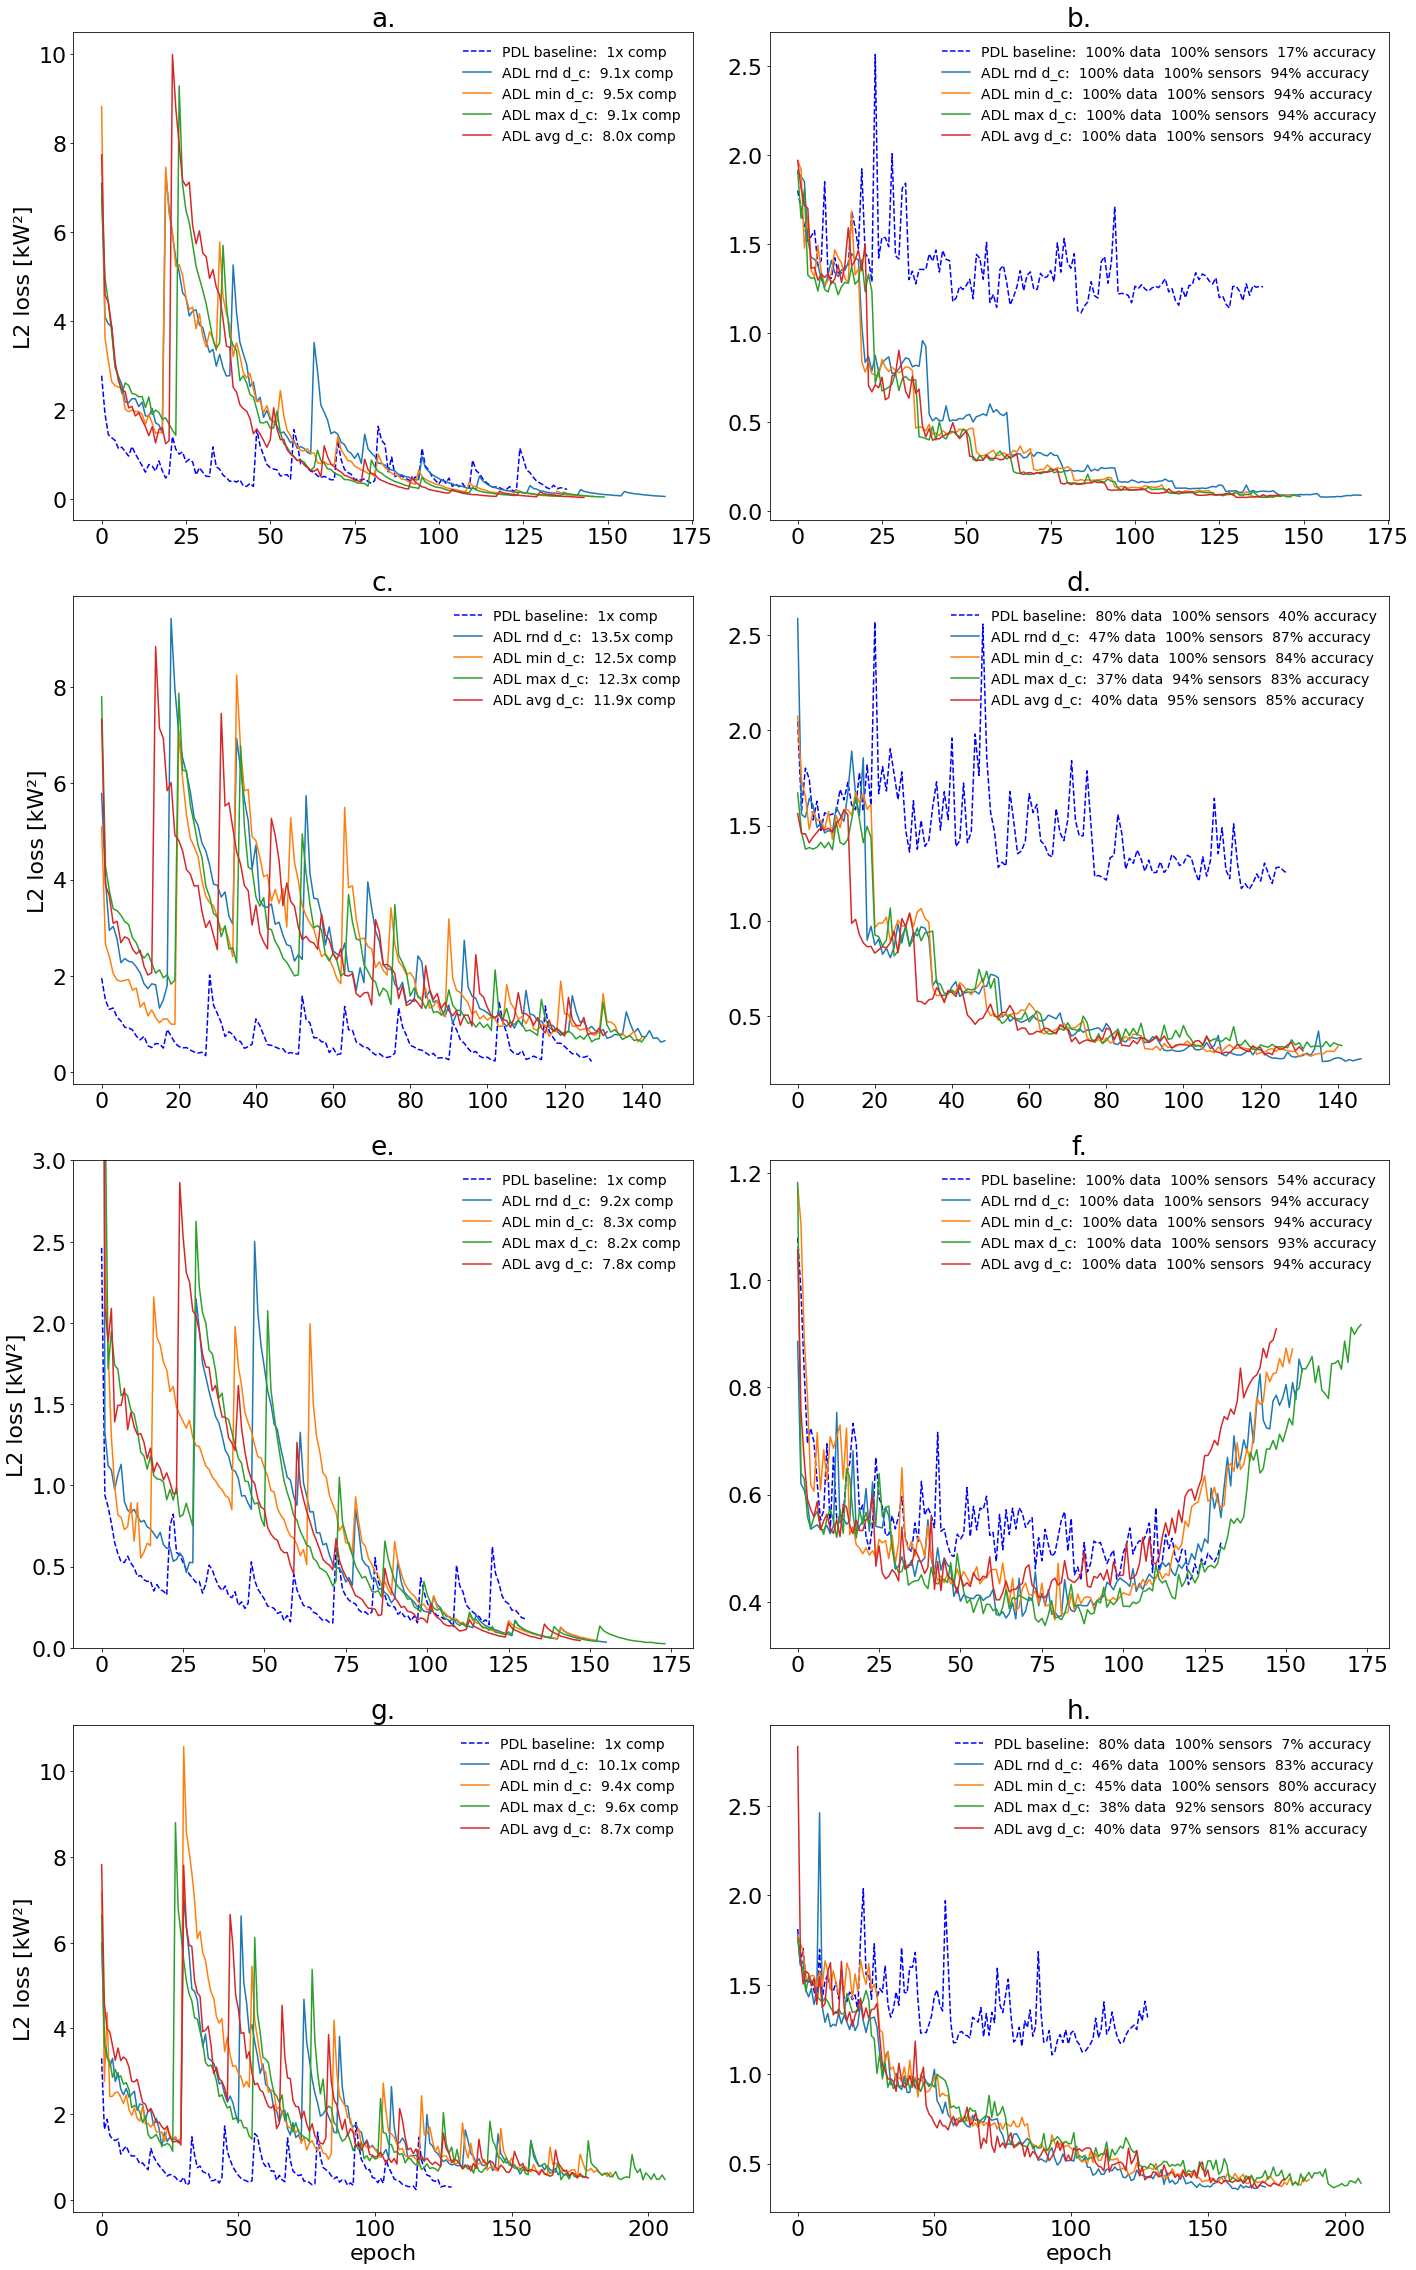

In [9]:
vis_results.plot_results_summary(HYPER_VIS)

## 9. Manuscript figure: Heuristics summary

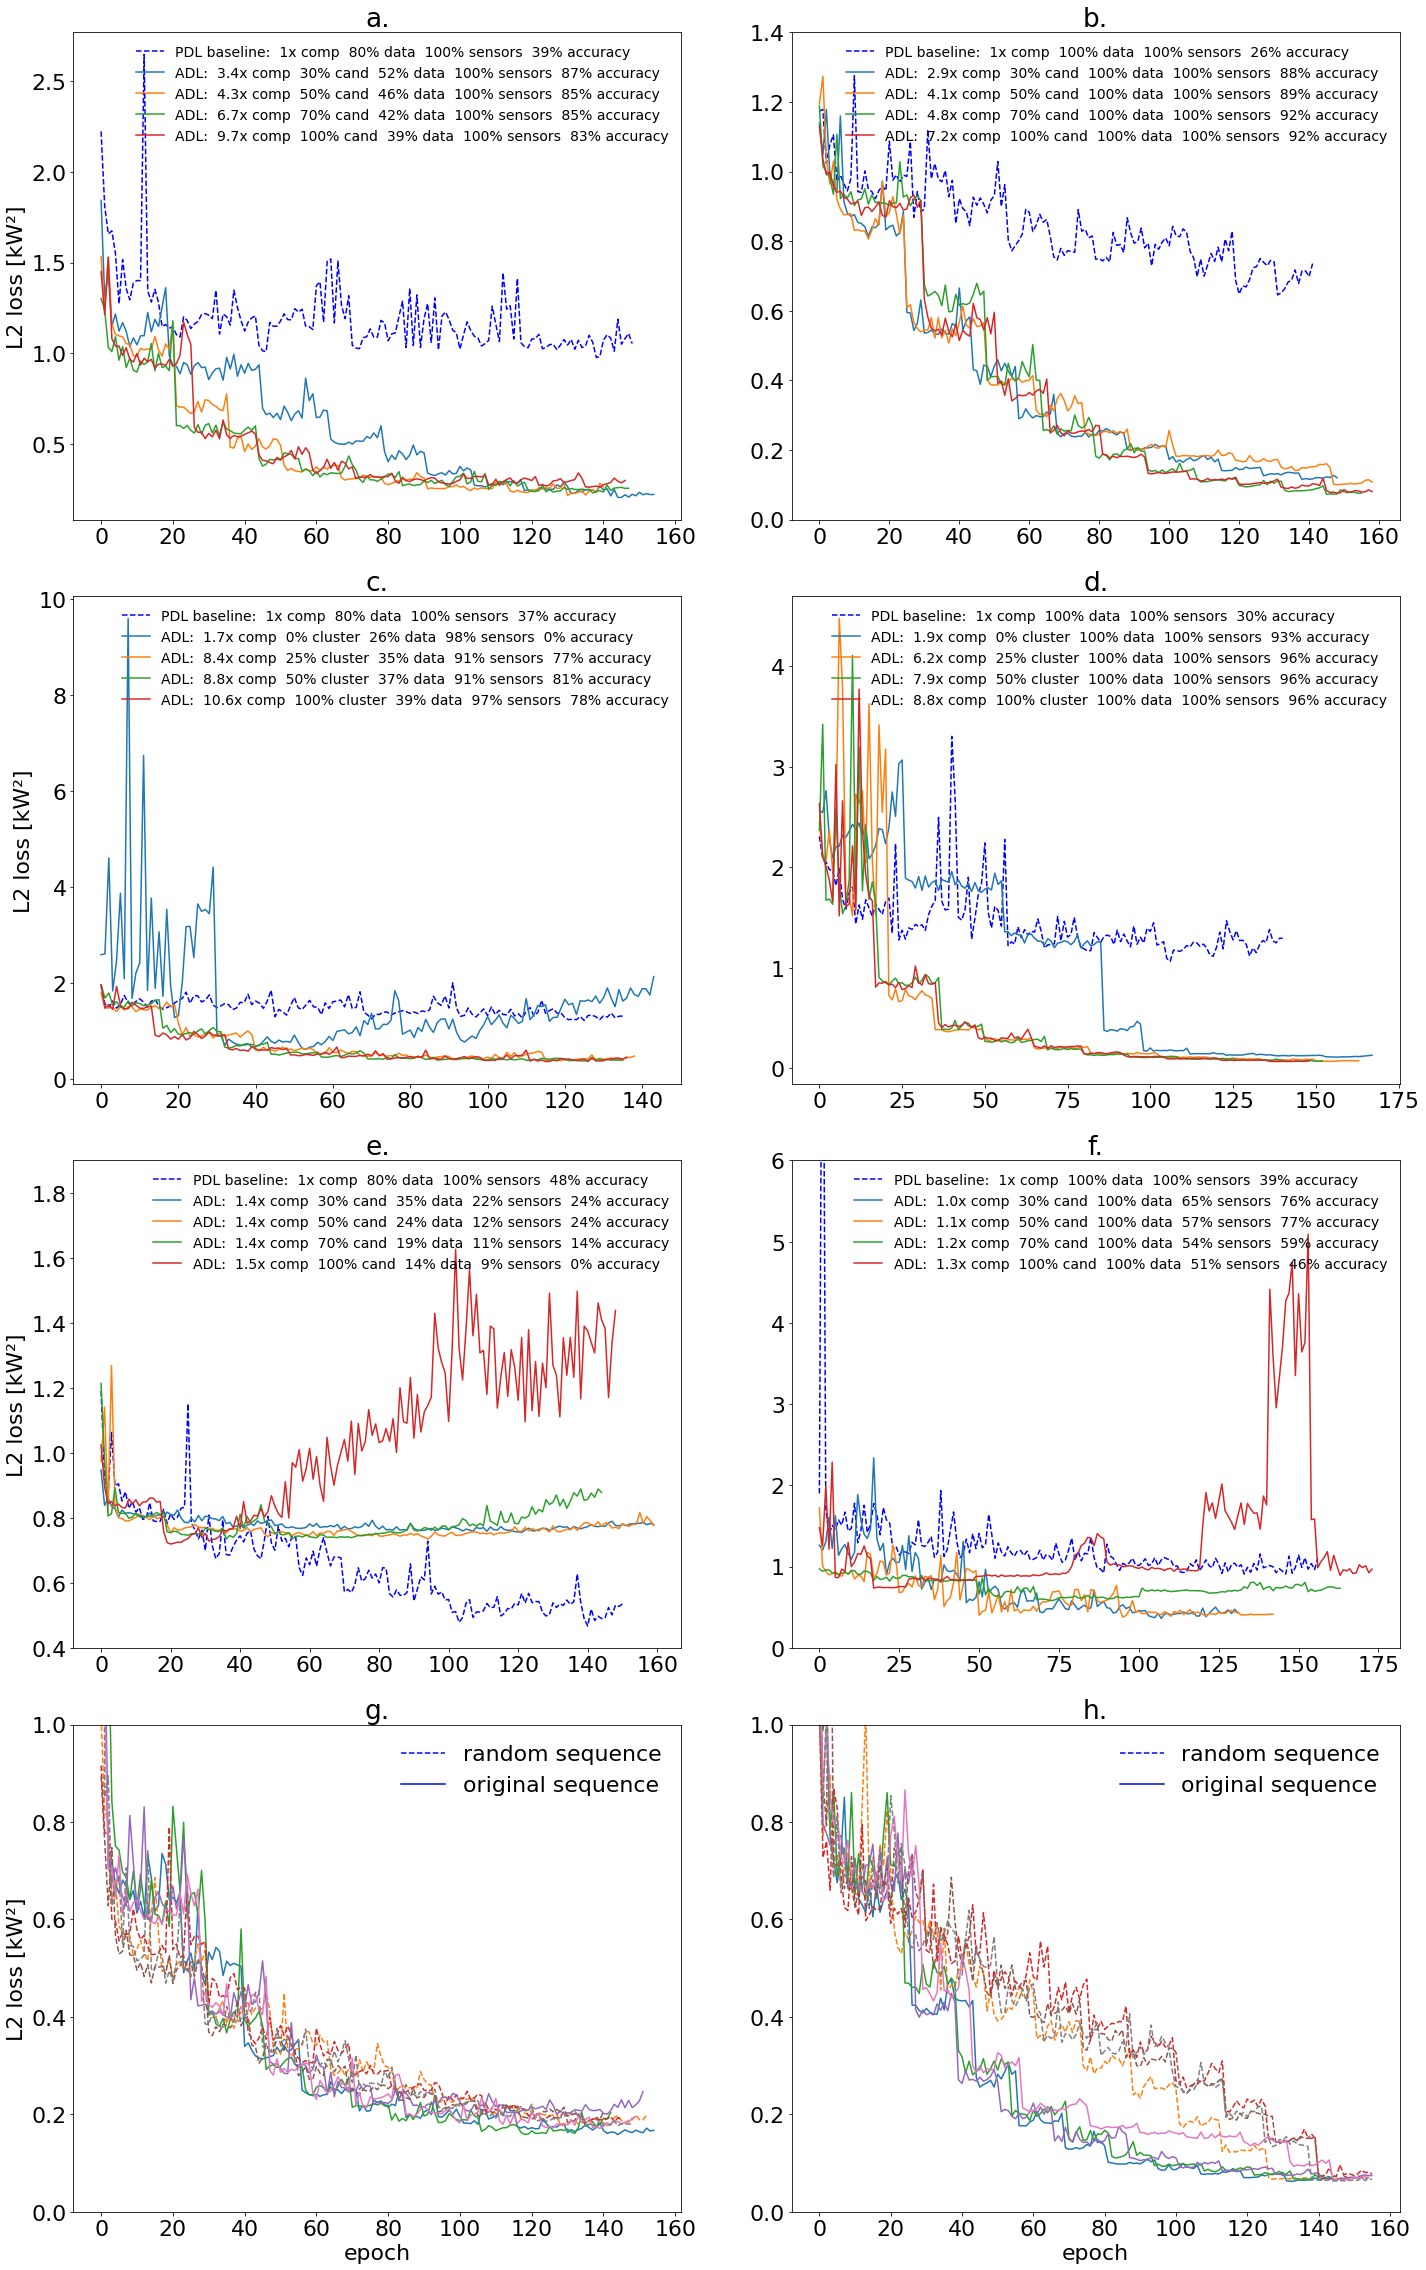

In [10]:
vis_results.plot_results_summary(HYPER_VIS, 'heuristic_summary')